# Spark and Pandas and Movies
I found some data online which is of some interest about movies and TV shows. And, no, this is not he IMBD data set which floats around for people's use but is instead from someone on [Kaggle](https://www.kaggle.com/datasets/aklimarimi/thriller-crime-action) which scraped lots of different websites for Thriller, Crime and Action shows. The dataset is small enough to be used with Pandas but large enough to be used to practice some Apache Spark! So, let's get to it.

# Pandas for Exploration
Exploring a bit of the data for problems is what I'd normally do. With Pandas, we can limit the number of rows imported to check for obvious problems before we start expanding our analysis to the whole dataset. This might seem odd considering that pandas can definitely import all this data but this is practice for larger datasets. There will be data which is simply too much for pandas but is not for Apache Spark. And, this is when using Spark will be useful but we also want the data to be as clean as possible before starting to work with it in spark. The last thing I want to do is have to try to clean the data in Spark on the fly or have to re-import data over and over for easily preventable problems.

For our initial check, we'll spot check the data.

In [16]:
import pandas as pd
from pathlib import Path

data = pd.read_csv(Path('data', 'AllThrillerSeriesList.csv'), nrows = 500)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            500 non-null    int64  
 1   Name                  500 non-null    object 
 2   Year                  500 non-null    object 
 3   Tv Certificate        461 non-null    object 
 4   Duration per episode  478 non-null    object 
 5   Genre                 500 non-null    object 
 6   Ratings               500 non-null    float64
 7   Actor/Actress         500 non-null    object 
 8   Votes                 500 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 35.3+ KB


In [23]:
#| include: false
data = pd.read_csv(Path('data', 'AllThrillerSeriesListClean.csv'), nrows = 500)

First thing of note is that there is this weird `Unnamed: 0` Column in the data. I also see that there are quite a few columns coming in as String objects when they definitely should be coming in as Intergers: such as the Year or Ratings or Votes. At least `Ratings` did come in correctly as a Float object for aggregation. Let's check the actual values.

In [2]:
data.head()

,Unnamed: 0,Name,Year,Tv Certificate,Duration per episode,Genre,Ratings,Actor/Actress,Votes
0,0,Andor,2022–,TV-14,40 min,"Action, Adventure, Drama",8.4,"Diego Luna, Kyle Soller, Stellan Skarsgård, G...","82,474"
1,1,The Peripheral,2022–,TV-MA,NaN,"Drama, Mystery, Sci-Fi",8.0,"Chloë Grace Moretz, Gary Carr, Jack Reynor, J...","34,768"
2,2,The Walking Dead,2010–2022,TV-MA,44 min,"Drama, Horror, Thriller",8.1,"Andrew Lincoln, Norman Reedus, Melissa McBrid...","988,666"
3,3,Criminal Minds,2005–,TV-14,42 min,"Crime, Drama, Mystery",8.1,"Kirsten Vangsness, Matthew Gray Gubler, A.J. ...","198,262"
4,4,Breaking Bad,2008–2013,TV-MA,49 min,"Crime, Drama, Thriller",9.5,"Bryan Cranston, Aaron Paul, Anna Gunn, Betsy ...","1,872,005"


So, the `Unnamed` column is some sort of index column. We wont need that for anything so we'll definitely be dropping that. The `Year` column is actually the Years the show was running as oppposed to the year it was released. The votes failed to import as numbers because they have a comma in them; this is common with web scraping and we can simply remove it and convert it to a number. We also have a missing value for the `Duration per Episode` column. And, lastly, I dislike these column names and we'll need to fix so that they're something more usable.

In [24]:
colReplace = ['Ignore', 'Name', 'Year', 'Guide', 'Duration', 'Genres', 'Ratings', 'Actors', 'Votes']
data.columns = colReplace
data = data.drop('Ignore', axis=1)

data.head(10)

,Name,Year,Guide,Duration,Genres,Ratings,Actors,Votes
0,Andor,2022–,TV-14,40 min,"Action, Adventure, Drama",8.4,"Diego Luna, Kyle Soller, Stellan Skarsgård, G...","82,474"
1,The Peripheral,2022–,TV-MA,NaN,"Drama, Mystery, Sci-Fi",8.0,"Chloë Grace Moretz, Gary Carr, Jack Reynor, J...","34,768"
2,The Walking Dead,2010–2022,TV-MA,44 min,"Drama, Horror, Thriller",8.1,"Andrew Lincoln, Norman Reedus, Melissa McBrid...","988,666"
3,Criminal Minds,2005–,TV-14,42 min,"Crime, Drama, Mystery",8.1,"Kirsten Vangsness, Matthew Gray Gubler, A.J. ...","198,262"
4,Breaking Bad,2008–2013,TV-MA,49 min,"Crime, Drama, Thriller",9.5,"Bryan Cranston, Aaron Paul, Anna Gunn, Betsy ...","1,872,005"
5,Dark,2017–2020,TV-MA,60 min,"Crime, Drama, Mystery",8.7,"Louis Hofmann, Karoline Eichhorn, Lisa Vicari...","384,702"
6,Manifest,2018–,TV-14,43 min,"Drama, Mystery, Sci-Fi",7.1,"Melissa Roxburgh, Josh Dallas, J.R. Ramirez, ...","66,158"
7,Stranger Things,2016–,TV-14,51 min,"Drama, Fantasy, Horror",8.7,"Millie Bobby Brown, Finn Wolfhard, Winona Ryd...","1,179,168"
8,Guillermo del Toro's Cabinet of Curiosities,2022–,TV-MA,60 min,"Drama, Horror, Mystery",7.1,"Lize Johnston, Kevin Keppy, Kate Micucci, F. ...","33,660"
9,Echo 3,2022–,TV-MA,49 min,"Action, Drama, Thriller",6.6,"Michiel Huisman, Luke Evans, Jessica Ann Coll...","1,333"


Better.
Now, I would like to now if a series is ongoing or not since this might be meaningful information. Looking at the format of the `Year` column, we can check if the last character is a `-` and that should tell us if the movie is ongoing or not. Of course, when you try this is does not work because the `Year` has extra space around it:

In [51]:
data.head(10).Year.apply(lambda x: x[-1])

0     
1     
2    2
3     
4    3
5    0
6     
7     
8     
9     
Name: Year, dtype: object

So, we will need to clear out that extra space before we can get what we want:

In [52]:
data.head(10).Year.apply(lambda x: x.strip()[-1] == '-')

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8    False
9    False
Name: Year, dtype: bool

Looking at the columns above, that's not correct so what is going on? Turns out that the character at the end is in fact not a hypen but something else that looks like a hyphen. Or, it might be some form of encoding mismatch becuase it's not the same thing:

In [53]:
data.Year.iloc[1].strip()[-1] == '-'

False

Rather than figure out what exactly it is, we're just going to copy it.

In [21]:
data.head(10).Year.apply(lambda x: x.strip()[-1] == '–')

0     True
1     True
2    False
3     True
4    False
5    False
6     True
7     True
8     True
9     True
Name: Year, dtype: bool

The starting year would actually be useful to know about since there are disagreements about which years of movies have the best shows. Pulling that out is going to be really simple. We'll just strip the extra white space, split on our weird hyphen and then pull the first value:

In [22]:
data.head(10).Year.apply(lambda x: x.split('–')[0])

0    2022
1    2022
2    2010
3    2005
4    2008
5    2017
6    2018
7    2016
8    2022
9    2022
Name: Year, dtype: object

And, fix the votes:

In [23]:
data.head(10).Votes.apply(lambda x: int(x.replace(',', '')))

0      82474
1      34768
2     988666
3     198262
4    1872005
5     384702
6      66158
7    1179168
8      33660
9       1333
Name: Votes, dtype: int64

In [25]:
#| include: False
data['isOngoing'] = data.Year.apply(lambda x: x.strip()[-1] == '–')
data['startYear'] = data.Year.apply(lambda x: x.split('–')[0])
data['Votes'] = data.Votes.apply(lambda x: int(x.replace(',', '')))
data.head(15)

,Name,Year,Guide,Duration,Genres,Ratings,Actors,Votes,isOngoing,startYear
0,Andor,2022–,TV-14,40 min,"Action, Adventure, Drama",8.4,"Diego Luna, Kyle Soller, Stellan Skarsgård, G...",82474,True,2022
1,The Peripheral,2022–,TV-MA,NaN,"Drama, Mystery, Sci-Fi",8.0,"Chloë Grace Moretz, Gary Carr, Jack Reynor, J...",34768,True,2022
2,The Walking Dead,2010–2022,TV-MA,44 min,"Drama, Horror, Thriller",8.1,"Andrew Lincoln, Norman Reedus, Melissa McBrid...",988666,False,2010
3,Criminal Minds,2005–,TV-14,42 min,"Crime, Drama, Mystery",8.1,"Kirsten Vangsness, Matthew Gray Gubler, A.J. ...",198262,True,2005
4,Breaking Bad,2008–2013,TV-MA,49 min,"Crime, Drama, Thriller",9.5,"Bryan Cranston, Aaron Paul, Anna Gunn, Betsy ...",1872005,False,2008
5,Dark,2017–2020,TV-MA,60 min,"Crime, Drama, Mystery",8.7,"Louis Hofmann, Karoline Eichhorn, Lisa Vicari...",384702,False,2017
6,Manifest,2018–,TV-14,43 min,"Drama, Mystery, Sci-Fi",7.1,"Melissa Roxburgh, Josh Dallas, J.R. Ramirez, ...",66158,True,2018
7,Stranger Things,2016–,TV-14,51 min,"Drama, Fantasy, Horror",8.7,"Millie Bobby Brown, Finn Wolfhard, Winona Ryd...",1179168,True,2016
8,Guillermo del Toro's Cabinet of Curiosities,2022–,TV-MA,60 min,"Drama, Horror, Mystery",7.1,"Lize Johnston, Kevin Keppy, Kate Micucci, F. ...",33660,True,2022
9,Echo 3,2022–,TV-MA,49 min,"Action, Drama, Thriller",6.6,"Michiel Huisman, Luke Evans, Jessica Ann Coll...",1333,True,2022


## Explode a Column!
This is surprisignly common in R but not very much in Python for some reason. When I was initially trying to work on these sorts of problems, I found that `explode()` was not something which was supported with Python. It did exists in Apache Spark - which is where I found the actual name for this action - so I had to work on writing my own. Thankfully, I don't have to keep track of my worse version and use the official call now.

To explode a column means to duplicate rows by splitting up the values in a column. If we look at the [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.explode.html#pandas-dataframe-explode) for this:

In [33]:
import numpy as np
df = pd.DataFrame({'A': [[0, 1, 2], 'foo', [], [3, 4]],
                   'B': 1,
                   'C': [['a', 'b', 'c'], np.nan, [], ['d', 'e']]})
df

,A,B,C
0,"[0, 1, 2]",1,"[a, b, c]"
1,foo,1,NaN
2,[],1,[]
3,"[3, 4]",1,"[d, e]"


In [35]:
df.explode('A')

,A,B,C
0,0,1,"[a, b, c]"
0,1,1,"[a, b, c]"
0,2,1,"[a, b, c]"
1,foo,1,NaN
2,NaN,1,[]
3,3,1,"[d, e]"
3,4,1,"[d, e]"


For our data, we'll want to do this for the `Genre` and the `Actor` columns. You will notice that to do this we'll need the column to contain a list instead of the comma separated values we have now. A quick `assign` and `apply` will fix this for us.

In [26]:
# TIME TO EXPLODE
# I am so happy this is a thing.
data = data.assign(
    Genre = data.Genres.apply(lambda x: x.split(',')),
    Actor = data.Actors.apply(lambda x: x.split(','))
)
data = data.explode('Genre')
data = data.explode('Actor')

data = data.assign(
    Genre = data.Genre.apply(lambda x: x.strip()),
    Actor = data.Actor.apply(lambda x: x.strip())
)

In [6]:
data.head(15)[['Name', 'Year', 'Genre', 'Actor']]

,Name,Year,Genre,Actor
0,Andor,2022–,Action,Diego Luna
0,Andor,2022–,Action,Kyle Soller
0,Andor,2022–,Action,Stellan Skarsgård
0,Andor,2022–,Action,Genevieve O'Reilly
0,Andor,2022–,Adventure,Diego Luna
0,Andor,2022–,Adventure,Kyle Soller
0,Andor,2022–,Adventure,Stellan Skarsgård
0,Andor,2022–,Adventure,Genevieve O'Reilly
0,Andor,2022–,Drama,Diego Luna
0,Andor,2022–,Drama,Kyle Soller


Nice! Now we can compare actors and genres!

## Data Cleaning
It is here we'll need to step aside since there were problems which this data. I believe I found this while exploring some basic questions but in effect, there are parenthesis included in the `Year` column:

In [7]:
data.Year.loc[data.Year.str.contains('\(')]

45     II) (2020–2023
45     II) (2020–2023
45     II) (2020–2023
45     II) (2020–2023
45     II) (2020–2023
            ...      
474     I) (2013–2016
474     I) (2013–2016
474     I) (2013–2016
474     I) (2013–2016
474     I) (2013–2016
Name: Year, Length: 192, dtype: object

Now, we could read each column and replace all these values but I think the better idea here will be to simply correct the source data. Keep in mind that if this is a dataset which pandas struggles with due to it's size then going with the replace is going to be the better option but I corrected the Source file in this instance. To fix this, I ran these two lines:
```bash
sed 's|II) (||'  data/AllThrillerSeriesList.csv > data/AllThrillerSeriesListCleaned.csv
sed 's|I) (||'  data/AllThrillerSeriesListCleaned.csv > data/AllThrillerSeriesListClean.csv
```

You should always keep the original copy around in case you need to undo damage that you did in your analysis on accident. Regardless of our best intentions, that will sometimes happen and you'll want to be able to start again.

Sadly, this still was not enough as there were more problems to fix. When I added more rows, I found that there was extra information in some of the Ratings columns - namely there was a attached `| Gross` which showed up:
```bash
[data]$ grep -i gross AllThrillerSeriesList.csv 
85,Mindhunter,2017–2019,TV-MA , 60 min ," Crime, Drama, Mystery",8.6," Jonathan Groff, Holt McCallany, Anna Torv, Hannah Gross"," 288,604"
669,Wallander,2005–2013,TV-14 , 90 min ," Crime, Drama, Mystery",7.6," Krister Henriksson, Fredrik Gunnarsson, Mats Bergman, Douglas Johansson"," 5,844 | Gross"
736,The Brave,2017–2018,TV-14 , 43 min ," Action, Drama, Thriller",7.5," Anne Heche, Mike Vogel, Tate Ellington, Demetrius Grosse"," 9,208"
931,Gongjo,2017– ,Not Rated , 124 min ," Action, Comedy, Drama",6.6," Hyun Bin, Hae-Jin Yoo, Ju-hyuk Kim, Lee Hae-Young"," 3,637 | Gross"
1115,Crisis,2014,,60 min ," Action, Drama, Thriller",7.0," Dermot Mulroney, Rachael Taylor, Lance Gross, James Lafferty"," 8,498"
1181,Hello Monster,2015,,,"Action, Crime, Mystery",7.7," Seo In-Guk, Jang Na-ra, Park Bo-gum, Choi Wonyoung"," 1,542 | Gross"
1978,Deadwax,2018– ,,,"Horror, Music, Mystery",6.7," Hannah Gross, Evan Gamble, Tracy Perez, Dohn Norwood", 397
[data]$
```

I admit that I simply went into the dataset and deleted them the first time around. But, that was because I already had the file open after finding out that the `Names` field was also not clean. Meaning that some of the names were not quoted like they should of been:
```bash
2220,Keple,s) (2018–2019,,,"Crime, Drama, Mystery",6.1," Marc Lavoine, Sofia Essaïdi, Isabelle Renauld, Serge Riaboukine", 97
```
If you look that TV Show up you'll find that it's name is `Kepler(s)` which is going to be a problem.

### If We Had a Data Engineer...
So, about now if we had a Data Engineer then we should reach out about how this all is being processed and cleaned up. These kinds of problems are going to make the analysis hard until we get these corrected upstream. In my case, since I have no say in the original data, we're going to have to step back and investigate our replaces once again to make sure we're not malforming the names when we substitute.

Reseting the data and checking through the data for the `) (` to look for fields which need to be correct, I found that there was another tier up of these weird patterns: `III) (`. So, these are our replaces with sed:
```bash
sed 's|III) (||'  data/AllThrillerSeriesList.csv > data/AllThrillerSeriesListCleaned.csv
sed -i 's|II) (||'  data/AllThrillerSeriesListCleaned.csv
sed -i 's|I) (||'  data/AllThrillerSeriesListCleaned.csv
sed 's|) (||'  data/AllThrillerSeriesListCleaned.csv > data/AllThrillerSeriesListClean.csv
```

I also found at least four rows where we'll need to add proper quotations marks around the values:
```
369,The Guardians of Justice,Will Save You!) (2022– ,TV-MA , 30 min ," Animation, Action, Adventure",5.0," Dallas Page, Sharni Vinson, Denise Richards, Zachery Ty Bryan"," 3,279"

2258,Doute Raisonnable,Reasonable Doubt) (2021– ,,60 min , Thriller,6.9," Marc-André Grondin, Julie Perreault, Kathleen Fortin, Dominik Dagenais", 39

2550,The Hunt for Salamander,Otdel Izdirvane) (2021– ,,,Thriller,9.1," Martin Radoev, Iva Mihalic, Hristo Petkov, Julian Vergov", 67

2760,Loabat Al Moot,Game of Death) (2013–2014,,57 min ," Drama, Family, Romance",6.2," Cyrine AbdelNour, Nicolas Mouawad, Nada Abou Farhat, Abed Fahd", 55
```

Just to show how this was updated:
```bash
[Nbks]$ grep -E "349,|2258,|2550,|2760," data/AllThrillerSeriesListClean.csv 
349,La Reina del Sur,2011– ,TV-MA , 378 min ," Action, Crime, Drama",7.9," Kate del Castillo, Humberto Zurita, Alejandro Calva, Isabella Sierra"," 2,728"
1349,Matrix,1993,,60 min ," Action, Drama, Fantasy",7.8," Nick Mancuso, Phillip Jarrett, Carrie-Anne Moss, John Vernon", 199
2258,"Doute Raisonnable,Reasonable Doubt", 2021– ,,60 min , Thriller,6.9," Marc-André Grondin, Julie Perreault, Kathleen Fortin, Dominik Dagenais", 39
2349,Swift Justice,1996,,,"Action, Crime, Thriller",7.0," James McCaffrey, Emerson St. John, Tony Darrow, Alex Kilgore", 61
2550,"The Hunt for Salamander,Otdel Izdirvane", 2021– ,,,Thriller,9.1," Martin Radoev, Iva Mihalic, Hristo Petkov, Julian Vergov", 67
2760,"Loabat Al Moot,Game of Death", 2013–2014,,57 min ," Drama, Family, Romance",6.2," Cyrine AbdelNour, Nicolas Mouawad, Nada Abou Farhat, Abed Fahd", 55
[Nbks]$
```

Now we should have most of the issues ironed out to start trying to ask some fun questions.

## What kinds of Movies...?
Now we an start asking some questions about the data before we move to Spark. Looking at the data here are some fun questions:
1. Given a Genre, what is the average rating and the average number of votes?
2. Given an actor, what is the averagae rating and the average number of votes?
3. Given the Guide, what is the average rating and the average number of votes?
4. Given the Starting Year, what is the average rating and the average number of votes?

In [27]:
# Given a Genre, what is the average rating and the average number of votes?
data.groupby('Genre')[['Ratings', 'Votes']].mean().sort_values('Ratings', ascending=False).head(10)

,Ratings,Votes
Genre,,
Biography,8.300000,109127.333333
Animation,8.221622,46288.783784
Crime,7.627799,69710.181467
Mystery,7.568966,63459.632184
Romance,7.545455,49638.090909
Comedy,7.545000,24758.975000
Drama,7.537500,72898.041667
Action,7.526994,51595.000000
Thriller,7.511034,56173.862069


Wow, I did not expect **Biography** to be the most well rated category in the data. I like that though and wonder what kind of movies and shows are in that list; A question for another time.

In [28]:
# Given an actor, what is the averagae rating and the average number of votes?; Best
data.groupby('Actor')[['Ratings', 'Votes']].mean().sort_values('Ratings', ascending=False).head(10)

,Ratings,Votes
Actor,,
Aaron Paul,9.5,1872005.0
Anna Gunn,9.5,1872005.0
Betsy Brandt,9.5,1872005.0
Lance Reddick,9.3,339583.0
Dominic West,9.3,339583.0
Pratik Gandhi,9.3,144344.0
Anjali Barot,9.3,144344.0
Shreya Dhanwanthary,9.3,144344.0
Sonja Sohn,9.3,339583.0


In [29]:
data.groupby('Actor')[['Ratings', 'Votes']].mean().sort_values('Ratings', ascending=False).tail(10)

,Ratings,Votes
Actor,,
Zachery Ty Bryan,5.0,3279.0
Denise Richards,5.0,3279.0
Ella Balinska,4.1,40569.0
Tamara Smart,4.1,40569.0
Adeline Rudolph,4.1,40569.0
Siena Agudong,4.1,40569.0
Sandra Reyes,2.4,3510.0
Constanza Camelo,2.4,3510.0
Diego Trujillo,2.4,3510.0


Some of these I recognize and some I don't. Nothing too interesting I think here.

In [30]:
# Given the Guide, what is the average rating and the average number of votes?
data.groupby('Guide')[['Ratings', 'Votes']].mean().sort_values('Ratings', ascending=False)

,Ratings,Votes
Guide,,
TV-Y7-FV,7.900000,11485.000000
TV-PG,7.737895,31579.273684
TV-14,7.622013,72887.157233
TV-Y7,7.562500,15830.000000
TV-MA,7.539541,77243.647773
Not Rated,7.392857,11184.071429
PG-13,6.700000,3289.000000
TV-13,6.600000,1404.000000


Now this is somewhat interesting.
The `FV` means there is *Fantasy Violence*; the `PG` means *Parental Guidance*. The top ratings are more mature shows with an emphasis on violence. Considering the data we have - and who is certainly voting - this means audiences generally like violence more than they do not.

In [31]:
data.groupby('startYear')[['Ratings', 'Votes']].mean().sort_values('Ratings', ascending=False).head(10)

,Ratings,Votes
startYear,,
1959,9.100000,83920.000000
1955,8.500000,17597.000000
1989,8.466667,67447.000000
1974,8.350000,7413.500000
1993,8.333333,84556.000000
1961,8.300000,8012.000000
1971,8.300000,35793.000000
1990,8.266667,84247.666667
2006,8.214286,205522.428571


In [32]:
data.groupby('startYear')[['Ratings', 'Votes']].mean().sort_values('Ratings', ascending=False).tail(10)

,Ratings,Votes
startYear,,
2018,7.360870,40269.934783
2019,7.347826,23647.582609
1997,7.325000,29279.000000
2020,7.301563,30649.367188
2021,7.247200,29343.368000
2022,7.206550,16209.716157
1976,7.200000,6567.000000
1984,7.200000,14867.333333
1973,7.000000,5353.500000


The older shows are doing much better than the newer shows. There are some older years which do not do well; what happened in the 70s?

## Let's Add Apache Spark
If you're not aware then [Apache Spark ](https://spark.apache.org) is a tool for large scale data analytics. I'm sure it is used for Data Engineering as well since it can clean data at a massive scale - but we're not going to use it for that today.

You can use Spark from python quite easily and without needing a cluster. Just `python3 -m pip install pyspark` and you're off. I would definitely recommend that you modify the logging level which gets pushed into the terminal since this makes working and reading much easier. Also, if you're following along and you want to restart spark then you'll need to run `sc.stop()` or what you named your spark context.

In [61]:
#| include: false
sc.stop()

In [62]:
# Conf for config; context spark "cluster"
from pyspark import SparkConf, SparkContext
conf = SparkConf().setMaster("local[*]").setAppName("play")
sc = SparkContext(conf = conf)
sc.setLogLevel("ERROR")

# session to talk to the "cluster"
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("play").getOrCreate()

We've already identified the data types we want so we'll tag them on import. To do this, we'll need `types` since this is not brought in by default.


In [63]:

from pyspark.sql.types import *

# Define the schema:
shows = StructType([
    StructField('Ignore', IntegerType(), True),
    StructField('Name', StringType(), True),
    StructField('Year', StringType(), True),
    StructField('Guide', StringType(), True),
    StructField('Duration', StringType(), True),
    StructField('Genres', StringType(), True),
    StructField('Ratings', FloatType(), True),
    StructField('Actors', StringType(), True),
    StructField('Votes', StringType(), True),
])

And, now we bring in the data.

In [64]:
data = spark.read.csv(str(Path('data', 'AllThrillerSeriesListClean.csv')), header=True, schema=shows)
data.show(10)

+------+--------------------+---------+------+--------+--------------------+-------+--------------------+----------+
|Ignore|                Name|     Year| Guide|Duration|              Genres|Ratings|              Actors|     Votes|
+------+--------------------+---------+------+--------+--------------------+-------+--------------------+----------+
|     0|               Andor|   2022– |TV-14 | 40 min | Action, Adventur...|    8.4| Diego Luna, Kyle...|    82,474|
|     1|      The Peripheral|   2022– |TV-MA |    null| Drama, Mystery, ...|    8.0| Chloë Grace More...|    34,768|
|     2|    The Walking Dead|2010–2022|TV-MA | 44 min | Drama, Horror, T...|    8.1| Andrew Lincoln, ...|   988,666|
|     3|      Criminal Minds|   2005– |TV-14 | 42 min | Crime, Drama, My...|    8.1| Kirsten Vangsnes...|   198,262|
|     4|        Breaking Bad|2008–2013|TV-MA | 49 min | Crime, Drama, Th...|    9.5| Bryan Cranston, ...| 1,872,005|
|     5|                Dark|2017–2020|TV-MA | 60 min | Crime, D

And, now we need to repeat what we prototyped in the pandas starting with dropping the column.

In [65]:
data = data.drop('Ignore')
data.show(10)

+--------------------+---------+------+--------+--------------------+-------+--------------------+----------+
|                Name|     Year| Guide|Duration|              Genres|Ratings|              Actors|     Votes|
+--------------------+---------+------+--------+--------------------+-------+--------------------+----------+
|               Andor|   2022– |TV-14 | 40 min | Action, Adventur...|    8.4| Diego Luna, Kyle...|    82,474|
|      The Peripheral|   2022– |TV-MA |    null| Drama, Mystery, ...|    8.0| Chloë Grace More...|    34,768|
|    The Walking Dead|2010–2022|TV-MA | 44 min | Drama, Horror, T...|    8.1| Andrew Lincoln, ...|   988,666|
|      Criminal Minds|   2005– |TV-14 | 42 min | Crime, Drama, My...|    8.1| Kirsten Vangsnes...|   198,262|
|        Breaking Bad|2008–2013|TV-MA | 49 min | Crime, Drama, Th...|    9.5| Bryan Cranston, ...| 1,872,005|
|                Dark|2017–2020|TV-MA | 60 min | Crime, Drama, My...|    8.7| Louis Hofmann, K...|   384,702|
|         

We need to replicate the custom functions like we did with the `isOngoing` column. To do this, we'll need to define our own functions in Spark and that requires **User Defined Functions**. There are different ways to do this but I think my favorite so far - which is the closest to a python lambda function - is defining it and using it inline:

In [66]:
# collect the ability to define udfs
import pyspark.sql.functions as F

data = data.withColumn('isOngoing',     # Target this column
    F.udf(                              # define a udf
        lambda x: x.strip()[-1] == '–') # use the logic we already wrote.
    ('Year')                            # pass the column we're applying this to.
)
data.select('isOngoing').show(10)

+---------+
|isOngoing|
+---------+
|     true|
|     true|
|    false|
|     true|
|    false|
|    false|
|     true|
|     true|
|     true|
|     true|
+---------+
only showing top 10 rows



With that, we can easily apply what we wrote before:

In [67]:

data = data.withColumn('startYear', F.udf( lambda x: x.split('–')[0])('Year'))
data = data.withColumn('Votes', F.udf( lambda x: int(x.replace(',', '')))('Votes'))
data = data.withColumn('Votes', F.cast(IntegerType(), data['Votes']))
data.show(10)

+--------------------+---------+------+--------+--------------------+-------+--------------------+-------+---------+---------+
|                Name|     Year| Guide|Duration|              Genres|Ratings|              Actors|  Votes|isOngoing|startYear|
+--------------------+---------+------+--------+--------------------+-------+--------------------+-------+---------+---------+
|               Andor|   2022– |TV-14 | 40 min | Action, Adventur...|    8.4| Diego Luna, Kyle...|  82474|     true|     2022|
|      The Peripheral|   2022– |TV-MA |    null| Drama, Mystery, ...|    8.0| Chloë Grace More...|  34768|     true|     2022|
|    The Walking Dead|2010–2022|TV-MA | 44 min | Drama, Horror, T...|    8.1| Andrew Lincoln, ...| 988666|    false|     2010|
|      Criminal Minds|   2005– |TV-14 | 42 min | Crime, Drama, My...|    8.1| Kirsten Vangsnes...| 198262|     true|     2005|
|        Breaking Bad|2008–2013|TV-MA | 49 min | Crime, Drama, Th...|    9.5| Bryan Cranston, ...|1872005|    f

The Actors and Genre work is easy in spark since it's inbuilt. We'll just split and explode like we did in pandas - but in spark:

In [68]:
data = data.withColumn('Genre', F.split(data['Genres'], ','))
data = data.withColumn('Genre', F.explode(data['Genre']))

data = data.withColumn('Actor', F.split(data['Actors'], ','))
data = data.withColumn('Actor', F.explode(data['Actor']))

# Gotta clean up the inputs:
data = data.withColumn('Genre', F.udf(lambda x: x.strip())('Genre'))
data = data.withColumn('Actor', F.udf(lambda x: x.strip())('Actor'))
data = data.withColumn('Votes', F.udf( lambda x: int(x) )('Votes'))

data.select(
    ['Name', 'Year', 'Guide', 
    'Duration', 'Ratings', 'Votes', 
    'isOngoing', 'startYear', 'Genre', 'Actor']
).show(10)

+-----+------+------+--------+-------+-----+---------+---------+---------+------------------+
| Name|  Year| Guide|Duration|Ratings|Votes|isOngoing|startYear|    Genre|             Actor|
+-----+------+------+--------+-------+-----+---------+---------+---------+------------------+
|Andor|2022– |TV-14 | 40 min |    8.4|82474|     true|     2022|   Action|        Diego Luna|
|Andor|2022– |TV-14 | 40 min |    8.4|82474|     true|     2022|   Action|       Kyle Soller|
|Andor|2022– |TV-14 | 40 min |    8.4|82474|     true|     2022|   Action| Stellan Skarsgård|
|Andor|2022– |TV-14 | 40 min |    8.4|82474|     true|     2022|   Action|Genevieve O'Reilly|
|Andor|2022– |TV-14 | 40 min |    8.4|82474|     true|     2022|Adventure|        Diego Luna|
|Andor|2022– |TV-14 | 40 min |    8.4|82474|     true|     2022|Adventure|       Kyle Soller|
|Andor|2022– |TV-14 | 40 min |    8.4|82474|     true|     2022|Adventure| Stellan Skarsgård|
|Andor|2022– |TV-14 | 40 min |    8.4|82474|     true|     2

In [58]:
# DELETE
data.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Guide: string (nullable = true)
 |-- Duration: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Ratings: float (nullable = true)
 |-- Actors: string (nullable = true)
 |-- Votes: string (nullable = true)
 |-- isOngoing: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Actor: string (nullable = true)



One mistake that will be eventually made is using other aggregation functions like pandas or the builtin to try to do aggregations. But, Spark has its own versions of these. You can find them under `pyspark.sql.functions` and import them as you like:

In [73]:
from pyspark.sql.functions import mean as sMean, col
try:
    data.select(['Genre', 'Ratings', 'Votes']).groupBy('Genre').agg(
        sMean('Ratings').alias("Mean"),
        sMean('Votes').alias('Votes')
        ).orderBy(F.desc("Mean")).show()
except Exception as e:
    print( e )

+---------+------------------+------------------+
|    Genre|              Mean|             Votes|
+---------+------------------+------------------+
|Biography| 7.795238108862014| 33137.95238095238|
|    Music| 7.474999845027924|           413.625|
|  History| 7.416666656732559|3330.5416666666665|
|Animation| 7.270712390319233| 8447.388742304309|
|  Fantasy| 7.231312224012695|18573.573755656107|
|Adventure| 7.228473101449998| 8999.588235294117|
|    Crime| 7.225606645016681|15978.954034326298|
|   Comedy| 7.223730058905348| 4206.774310595065|
|   Family| 7.207407372969168| 635.7592592592592|
|    Drama|7.2038561880837015| 17351.69541427827|
|     News| 7.199999809265137|              28.0|
|  Mystery| 7.192586999365133|15005.853252647505|
|   Action|7.1531927343807755| 11602.80236925744|
|  Romance| 7.139181296727811|3810.4619883040937|
| Thriller| 7.113366268083392| 6469.523950617284|
|   Horror| 7.089073947713345|15463.994670219854|
|   Sci-Fi| 7.085540543375789|21185.131081081083|


There are some which are definitely outliers - like Music, News and War. Biography is still a hard winner though.

There is no plotting functions inside of Spark so you will need to pull the data for visualizations. Spark has a handy function `.toPandas()` which will pull the data out and convert it into a pandas data frame for usage. Please make sure when you do this to only pull the results and not the totality of the data.

In [74]:
results = data.select(['Genre', 'Ratings', 'Votes']).groupBy('Genre').agg(
    sMean('Ratings').alias("Mean"),
    sMean('Votes').alias('Votes')
    ).orderBy(F.desc("Mean")).toPandas()

results.head(10)

,Genre,Mean,Votes
0,Biography,7.795238,33137.952381
1,Music,7.475000,413.625000
2,History,7.416667,3330.541667
3,Animation,7.270712,8447.388742
4,Fantasy,7.231312,18573.573756
5,Adventure,7.228473,8999.588235
6,Crime,7.225607,15978.954034
7,Comedy,7.223730,4206.774311
8,Family,7.207407,635.759259
9,Drama,7.203856,17351.695414


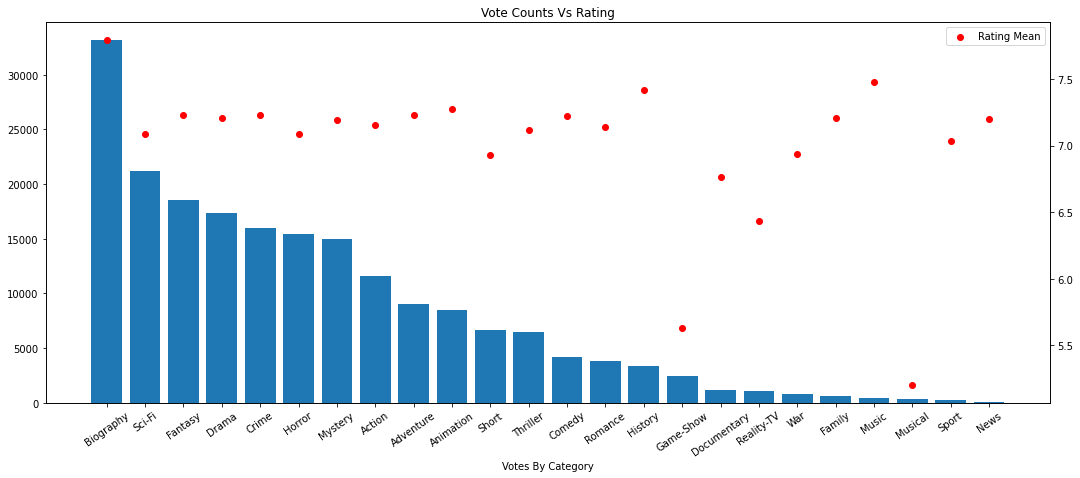

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (18,7)

fig, ax = plt.subplots()
tmp = results.sort_values('Votes', ascending=False)
ax.bar(tmp.Genre, tmp.Votes)
ax.set_xlabel('Votes By Category')
plt.xticks(rotation=35)

ax2 = ax.twinx()
ax2.scatter(tmp.Genre, tmp.Mean, color='red')
ax2.legend(loc='upper right', labels=['Rating Mean'])
plt.title("Vote Counts Vs Rating")
#plt.title("Relationships Between Votes and Their Ratings")
plt.show()

# Conclusions and Thoughts
There is a lot more we can do with this so we'll defintely continue in another post. It's questionable for data at this scale but it's good practice. Maybe next time we'll explore more of the Machine Learning tools Spark grants us.